# **XGboost - CAR SALES PREDICTION** 🚗

Esse Pipeline tem como objetivo construir um modelo de Machine Learning capaz de prever se um cliente comprará um carro, usando informações **como idade, salário anual e gênero.**

**A ideia é entender o comportamento do cliente e gerar insights que ajudem a planejar estratégias de marketing e vendas mais eficientes.**

O modelo utiliza XGBoost, um algoritmo de aprendizado supervisionado, que lida bem com desbalanceamento entre classes e entrega previsões confiáveis.

# 1. Pre-Tratamento da Base.

In [19]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [20]:
base = pd.read_csv('CARRO_CLIENTES.csv')

In [21]:
base

,User ID,Gender,Age,AnnualSalary,Purchased
0,385,Male,35,20000,0
1,681,Male,40,43500,0
2,353,Male,49,74000,0
3,895,Male,40,107500,1
4,661,Male,25,79000,0
...,...,...,...,...,...
995,863,Male,38,59000,0
996,800,Female,47,23500,0
997,407,Female,28,138500,1
998,299,Female,48,134000,1


In [22]:
print(base.dtypes)

User ID          int64
Gender          object
Age              int64
AnnualSalary     int64
Purchased        int64
dtype: object


A coluna Gender está como object (texto, por exemplo "Male" e "Female"), o XGBoost não aceita direto colunas categóricas em string. Vou transformar em números.

In [23]:
base['Gender']=base['Gender'].map({'Male':0,'Female':1})

In [24]:
base

,User ID,Gender,Age,AnnualSalary,Purchased
0,385,0,35,20000,0
1,681,0,40,43500,0
2,353,0,49,74000,0
3,895,0,40,107500,1
4,661,0,25,79000,0
...,...,...,...,...,...
995,863,0,38,59000,0
996,800,1,47,23500,0
997,407,1,28,138500,1
998,299,1,48,134000,1


### - Verificar Balanceamento da Coluna Target

In [25]:
# Contagem absoluta dos valores
print(base['Purchased'].value_counts())

# Contagem em percentual
print(base['Purchased'].value_counts(normalize=True) * 100)


Purchased
0    598
1    402
Name: count, dtype: int64
Purchased
0    59.8
1    40.2
Name: proportion, dtype: float64


**Insigth:** A Coluna Target possue valores relativamente Balanceados, mas para aumento da Robustez vou fazer uso da seguinte linha de codigo: scale_pos_weight = n_negativos / n_positivos
Para ser mais criteriosa, usarei o hiperparâmetro scale_pos_weight no XGBoost, que ajusta o peso da classe minoritária (1 = comprou).

In [26]:
for col in base.columns:
    print(f"{col}: {base[col].unique()}")

User ID: [ 385  681  353  895  661  846  219  588   85  465  686  408  790  116
  118   54   90  372  926   94  338  134  821  294  597  567   20  108
  105  994  273  263  423   88   81  257  755  249  121  489  555  222
  590  645  689  646  964  384  826   27  268  466  411  445  428  974
  828  348  730  820  917   15  365  674   30  531  190  160  371  321
  230  819  965  351  266  629  891  311  439  861  510  277  417  123
  912  667  435  722  892  279  500  684  414  349  456  485  960  233
  191  471  977  120  126   23  225  772  398  367  511  775  324  829
  478  546  942  571  375  905  132  438  972  596  395  663  903   25
  599  563  607  928  453  509  203  450  573  662  651   19  634  647
  693  728  520  213  142  322  540  743  887  241  701  848  782  877
  924   83  369  579  583  919  957  973  521   41   42  327  347  148
  443  700  738  527  742  175  335  996  378  655  104  221  786  536
  460  710  524  890   46   95   78  402  264   34  522  156  850   

###  - Verificando Valores Nulos

In [27]:
print(base.isnull().sum())

User ID         0
Gender          0
Age             0
AnnualSalary    0
Purchased       0
dtype: int64


Tudo Ok, por aqui!

###  - Dropando Coluna ID

In [28]:
# Limpa espaços no início/fim e tabs das colunas
base.columns = base.columns.str.strip()

# Agora dá para dropar a coluna User ID
base = base.drop(columns=['User ID'])

# Verifica resultado
print(base.head())


   Gender  Age  AnnualSalary  Purchased
0       0   35         20000          0
1       0   40         43500          0
2       0   49         74000          0
3       0   40        107500          1
4       0   25         79000          0


# 2. Matriz de correlação e analise as váriaveis que parecem ter maior correlação com a váriavel target (Puchased).

In [29]:
correlation_matrix=base.corr()

print(correlation_matrix)

                Gender       Age  AnnualSalary  Purchased
Gender        1.000000  0.084760      0.063301   0.047211
Age           0.084760  1.000000      0.166042   0.616036
AnnualSalary  0.063301  0.166042      1.000000   0.364974
Purchased     0.047211  0.616036      0.364974   1.000000


**Insigth:** As duas variaveis que possuem maiores correlacoes sao Idade e Salario Anual.

# 3. Separação da base em X e Y e em seguida nas bases de treino e teste.

In [30]:
# Target
Y = base['Purchased']

# Features
X = base.drop(columns=['Purchased'])


In [31]:
from sklearn.model_selection import train_test_split

# 70% treino, 30% teste
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42
)

# Verificando o tamanho dos conjuntos
print(f"Tamanho treino: {X_train.shape}")
print(f"Tamanho teste: {X_test.shape}")


Tamanho treino: (700, 3)
Tamanho teste: (300, 3)


# 4. Treino do modelo Xgboost com base de treino.


Quais os parametros que utilizarei para ajustar a robustez do XGBOOST.

- GridSearchCV para encontrar os melhores hiperparâmetros

- Balanceamento de classes com scale_pos_weight

- Early stopping usando callbacks (compatível com XGBoost >=1.7)

- Parametro de importancia principal e o Recall - Taxa de acerto de clientes que realmente irao comprar.


In [74]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Calcular scale_pos_weight
n_neg = sum(Y_train == 0)
n_pos = sum(Y_train == 1)
scale_pos_weight = n_neg / n_pos
print(f"Scale_pos_weight: {scale_pos_weight:.2f}")

# Criar conjunto de validação para early stopping
X_train_sub, X_val, Y_train_sub, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42
)

# GridSearchCV para encontrar melhores hiperparâmetros
model = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight
)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='recall',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_sub, Y_train_sub)
print("Melhores parâmetros GridSearchCV:", grid_search.best_params_)

# Treino final com API nativa do XGBoost + early stopping
# Criar DMatrix
dtrain = xgb.DMatrix(X_train_sub, label=Y_train_sub)
dval   = xgb.DMatrix(X_val, label=Y_val)
dtest  = xgb.DMatrix(X_test, label=Y_test)

# Parametros do modelo final
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "max_depth": grid_search.best_params_['max_depth'],
    "eta": grid_search.best_params_['learning_rate'],
    "subsample": grid_search.best_params_['subsample'],
    "colsample_bytree": grid_search.best_params_['colsample_bytree'],
    "scale_pos_weight": scale_pos_weight
}

evals = [(dtrain, "train"), (dval, "val")]

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=True
)



Scale_pos_weight: 1.55
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Melhores parâmetros GridSearchCV: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
[0]	train-logloss:0.68772	val-logloss:0.68892
[1]	train-logloss:0.68360	val-logloss:0.68551
[2]	train-logloss:0.67919	val-logloss:0.68226
[3]	train-logloss:0.67499	val-logloss:0.67920
[4]	train-logloss:0.67071	val-logloss:0.67605
[5]	train-logloss:0.66662	val-logloss:0.67305
[6]	train-logloss:0.66269	val-logloss:0.67016
[7]	train-logloss:0.65612	val-logloss:0.66458
[8]	train-logloss:0.65233	val-logloss:0.66143
[9]	train-logloss:0.64584	val-logloss:0.65611
[10]	train-logloss:0.64238	val-logloss:0.65320
[11]	train-logloss:0.63896	val-logloss:0.65045
[12]	train-logloss:0.63286	val-logloss:0.64522
[13]	train-logloss:0.62934	val-logloss:0.64230
[14]	train-logloss:0.62554	val-logloss:0.63956
[15]	train-logloss:0.62199	val-logloss:0.63687
[16]	train-logloss:0.61612	val-log

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:38:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[70]	train-logloss:0.44902	val-logloss:0.50138
[71]	train-logloss:0.44588	val-logloss:0.49894
[72]	train-logloss:0.44418	val-logloss:0.49769
[73]	train-logloss:0.44110	val-logloss:0.49531
[74]	train-logloss:0.43799	val-logloss:0.49275
[75]	train-logloss:0.43641	val-logloss:0.49171
[76]	train-logloss:0.43489	val-logloss:0.49080
[77]	train-logloss:0.43204	val-logloss:0.48877
[78]	train-logloss:0.43048	val-logloss:0.48775
[79]	train-logloss:0.42763	val-logloss:0.48553
[80]	train-logloss:0.42606	val-logloss:0.48444
[81]	train-logloss:0.42461	val-logloss:0.48355
[82]	train-logloss:0.42317	val-logloss:0.48240
[83]	train-logloss:0.42174	val-logloss:0.48140
[84]	train-logloss:0.42019	val-logloss:0.48011
[85]	train-logloss:0.41863	val-logloss:0.47894
[86]	train-logloss:0.41727	val-logloss:0.47797
[87]	train-logloss:0.41460	val-logloss:0.47586
[88]	train-logloss:0.41324	val-logloss:0.47506
[89]	train-logloss:0.41190	val-logloss:0.47414
[90]	train-logloss:0.41046	val-logloss:0.47315
[91]	train-lo

# 5. Previsões para a base de teste.

In [75]:
# Avaliação no conjunto de teste
y_pred_prob = bst.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)  # threshold 0.5

print("Acurácia no teste:", accuracy_score(Y_test, y_pred))
print("\nMatriz de Confusão:\n", confusion_matrix(Y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(Y_test, y_pred))
# -------------------------------



Acurácia no teste: 0.9033333333333333

Matriz de Confusão:
 [[156  16]
 [ 13 115]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.92      0.91      0.91       172
           1       0.88      0.90      0.89       128

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300



# 6. Feature importance.
As features mais importantes.

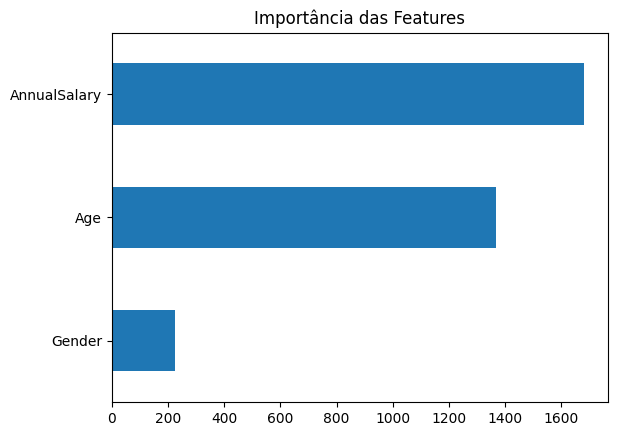

In [76]:
# Importância das features
feature_importances = pd.Series(bst.get_score(importance_type='weight'), index=X_train.columns)
feature_importances.sort_values(ascending=True).plot(kind='barh', title='Importância das Features')
plt.show()


**Insight:** As variáveis que mais impactaram a predição de vendas foram Salário Anual e Idade, indicando que clientes com maior renda e determinadas faixas etárias têm maior probabilidade de realizar a compra. A variável Gênero apresentou menor relevância individual, mas sua inclusão contribui para a robustez do modelo, ajudando a capturar padrões sutis no comportamento dos clientes.